In [ ]:
#Loading libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import pickle
from tqdm import tqdm
import os
from collections import Counter

## 1.1 Loading Data

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv', nrows=50000)
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
# calculating sentiment scores for the essay feature 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

data['sentiment_scores'] = data['essay'].apply(lambda essay: sid.polarity_scores(essay))
print(data.shape)
data.head(2)
#https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4#:~:text=It%20is%20built%20on%20top,an%20overall%20sentence%20sentiment%20score.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
(50000, 10)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,sentiment_scores
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,"{'neg': 0.013, 'neu': 0.783, 'pos': 0.205, 'co..."
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,"{'neg': 0.072, 'neu': 0.68, 'pos': 0.248, 'com..."


In [ ]:
# Spliting  data.
X = data.drop(['project_is_approved'], axis= 1)
print(X.shape)
X.head(2)
print('*==*'*10)
y = data['project_is_approved']
y.head(2)

(50000, 9)
*==**==**==**==**==**==**==**==**==**==*


0    1
1    1
Name: project_is_approved, dtype: int64

In [ ]:
# Spliting data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train,X_cv,y_train,y_cv = train_test_split(X_train, y_train, test_size =0.20, random_state =42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_cv.shape, y_cv.shape

((32000, 9), (32000,), (10000, 9), (10000,), (8000, 9), (8000,))

In [ ]:
preprocessed_essays = X_train['essay'].values

In [ ]:
# performing tfidf vectorization of text data.

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10) # Taken the words which occur at lease for 10 times
X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'].values) # Fit has to happen only on train data in order to avoid data leakeg
print("Shape of X_train_essay after tfidf ",X_train_essay_tfidf.shape)
print("+"*100)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)
print("shape after vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

Shape of X_train_essay after tfidf  (32000, 10167)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
shape after vectorizations
(32000, 10167) (32000,)
(8000, 10167) (8000,)
(10000, 10167) (10000,)


In [ ]:
#performing tfidf w2v vectorization of text data.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# computing average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)
print('=='*10)
print('\n',len(tfidf_w2v_vectors_train))
#print(tfidf_w2v_vectors_train)
print(len(tfidf_w2v_vectors_train[0]))

100%|██████████| 32000/32000 [01:14<00:00, 426.76it/s]


 32000
300


In [ ]:
# computing average word2vec for each review in cv.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

100%|██████████| 8000/8000 [00:18<00:00, 430.17it/s]


In [ ]:
# compute average word2vec for each review in test.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

100%|██████████| 10000/10000 [00:23<00:00, 426.70it/s]


In [ ]:
#performing encoding of categorical features.

# School_state
vectorizer_1 = CountVectorizer(binary=True)
X_train_school_state_ohe = vectorizer_1.fit_transform(X_train['school_state'].values)
print("Shape of matrix after one hot encodig for school_state ")

X_test_school_state_ohe = vectorizer_1.transform(X_test['school_state'].values)
X_cv_school_state_ohe = vectorizer_1.transform(X_cv['school_state'].values)
print(vectorizer_1.get_feature_names()) #Printing the features of school state
print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print('*'*100)



## Teacher_prefix
vectorizer_1 = CountVectorizer(binary=True)

X_train_teacher_prefix_ohe= vectorizer_1.fit_transform(X_train['teacher_prefix'].values)
print("Shape of matrix after one hot encodig for teacher_prefix ")

X_test_teacher_prefix_ohe = vectorizer_1.transform(X_test['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer_1.transform(X_cv['teacher_prefix'].values)
print(vectorizer_1.get_feature_names()) #Printing the features of teacher_prefix
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print('*'*100)

## project_grade_category
X_train_project_grade_category_ohe= vectorizer_1.fit_transform(X_train['project_grade_category'].values)
print("Shape of matrix after one hot encodig for project_grade_category ")

X_test_project_grade_category_ohe = vectorizer_1.transform(X_test['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer_1.transform(X_cv['project_grade_category'].values)
print(vectorizer_1.get_feature_names()) #Printing the features of project_grade_category
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print('*'*100)

## clean_categories
X_train_clean_categories_ohe= vectorizer_1.fit_transform(X_train['clean_categories'].values)
print("Shape of matrix after one hot encodig for clean_categories ")

X_test_clean_categories_ohe = vectorizer_1.transform(X_test['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer_1.transform(X_cv['clean_categories'].values)
print(vectorizer_1.get_feature_names()) #Printing the features of clean_categories
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print('*'*100)

## clean_subcategories
X_train_clean_subcategoriess_ohe= vectorizer_1.fit_transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig for clean_subcategories ")

X_test_clean_subcategories_ohe = vectorizer_1.transform(X_test['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer_1.transform(X_cv['clean_subcategories'].values)
print(vectorizer_1.get_feature_names()) #Printing the features of clean_subcategories
print(X_train_clean_subcategoriess_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print('*'*100)

Shape of matrix after one hot encodig for school_state 
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
(32000, 51) (32000,)
(8000, 51) (8000,)
(10000, 51) (10000,)
****************************************************************************************************
Shape of matrix after one hot encodig for teacher_prefix 
['dr', 'mr', 'mrs', 'ms', 'teacher']
(32000, 5) (32000,)
(8000, 5) (8000,)
(10000, 5) (10000,)
****************************************************************************************************
Shape of matrix after one hot encodig for project_grade_category 
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
(32000, 4) (32000,)
(8000, 4) (8000,)
(10000, 4) (10000,)
************************************

In [ ]:
# performing encoding of numerical features
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
# Normalizing the numerical feature i.e price
X_train_price = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
X_cv_price = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

#Getting the shape of trai, test, cv
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)
print('-'*100)

(32000, 1) (32000,)
(8000, 1) (8000,)
(10000, 1) (10000,)
----------------------------------------------------------------------------------------------------


In [ ]:
# For stack up all the tfidf vectorized features
from scipy.sparse import hstack
X_trian_stacked = hstack((X_train_essay_tfidf, X_train_school_state_ohe,X_train_teacher_prefix_ohe,X_train_project_grade_category_ohe,X_train_clean_categories_ohe,X_train_clean_subcategoriess_ohe,X_train_price,X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)))
X_cv_stacked = hstack((X_cv_essay_tfidf, X_cv_school_state_ohe,X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_price, X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)))
X_test_stacked = hstack((X_test_essay_tfidf, X_test_school_state_ohe,X_test_teacher_prefix_ohe,X_test_project_grade_category_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_price, X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)))

print("Final matrix")
print(X_trian_stacked.shape, y_train.shape)
print(X_cv_stacked.shape, y_cv.shape)
print(X_test_stacked.shape,y_test.shape)
#https://www.geeksforgeeks.org/numpy-hstack-in-python/

Final matrix
(32000, 10268) (32000,)
(8000, 10268) (8000,)
(10000, 10268) (10000,)


BEST MAX DEPTH:  10 
 BEST SCORE:  0.6098974158519068 
BEST MIN SAMPLE SPLIT:  500


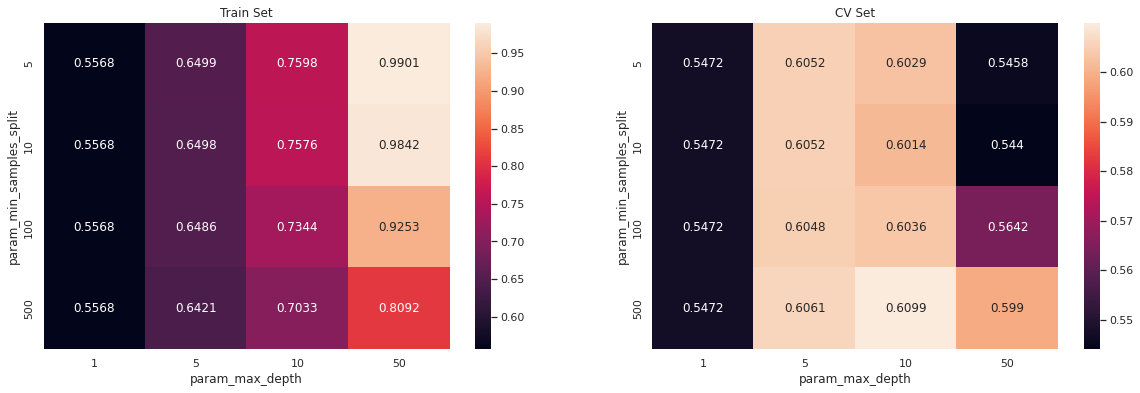

In [ ]:
#Importing required libraries
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


#Building decision tree model
dt_tfidf= DecisionTreeClassifier(class_weight = 'balanced')
# hyperparameter space
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf = GridSearchCV(dt_tfidf, parameters, cv=3, scoring='roc_auc',return_train_score=True,n_jobs =-1)
clf.fit(X_trian_stacked, y_train)

#IMP output parameters
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestMaxDepth_1=clf.best_params_['max_depth']
bestMinSampleSplit_1=clf.best_params_['min_samples_split']
bestScore_1=clf.best_score_
print("BEST MAX DEPTH: ",clf.best_params_['max_depth'], "\n BEST SCORE: ",clf.best_score_,"\nBEST MIN SAMPLE SPLIT: ",clf.best_params_['min_samples_split']) 



# Drawing Heat map instead of 3d plot as 3d plot is easily understand
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

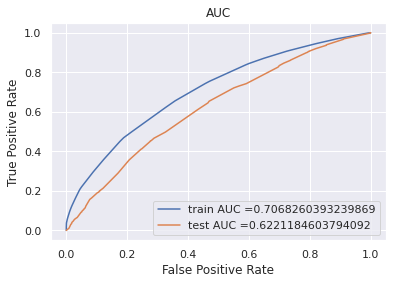

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

clf11= DecisionTreeClassifier(class_weight = 'balanced',min_samples_split=bestMinSampleSplit_1,max_depth=bestMaxDepth_1)
#clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
clf11.fit(X_trian_stacked, y_train)


y_train_pred1 = clf11.predict_proba(X_trian_stacked) [:,1]
predictions_train_set1=clf11.predict(X_trian_stacked)
y_test_pred1 = clf11.predict_proba(X_test_stacked) [:,1]
predictions_test_set1=clf11.predict(X_test_stacked)


train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC")
plt.grid(True)
plt.show()

In [ ]:
#Defining custom function
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

#https://www.kaggle.com/nikhilparmar9/decision-tree-donorschoose-dataset

the maximum value of tpr*(1-fpr) 0.4211827739836143 for threshold 0.517
the maximum value of tpr*(1-fpr) 0.347204186486372 for threshold 0.525


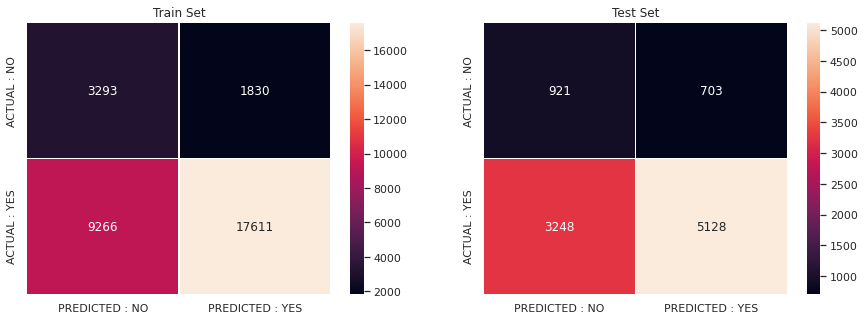

In [ ]:
#CONFUSION MATRIX

import seaborn as sns; sns.set()
print("="*100)
from sklearn.metrics import confusion_matrix

conf_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))


conf_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))

fig, ax = plt.subplots(1,2, figsize=(15,5))


sns.set(font_scale=1)#for label size
sns.heatmap(conf_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = True, fmt = '', ax=ax[0])
sns.heatmap(conf_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = True, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/

In [ ]:
#Analysis on the False positives
fpi = []
for i in range(len(y_test)) :
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
   fpi.append(i)

fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

len(fp_essay1)

703

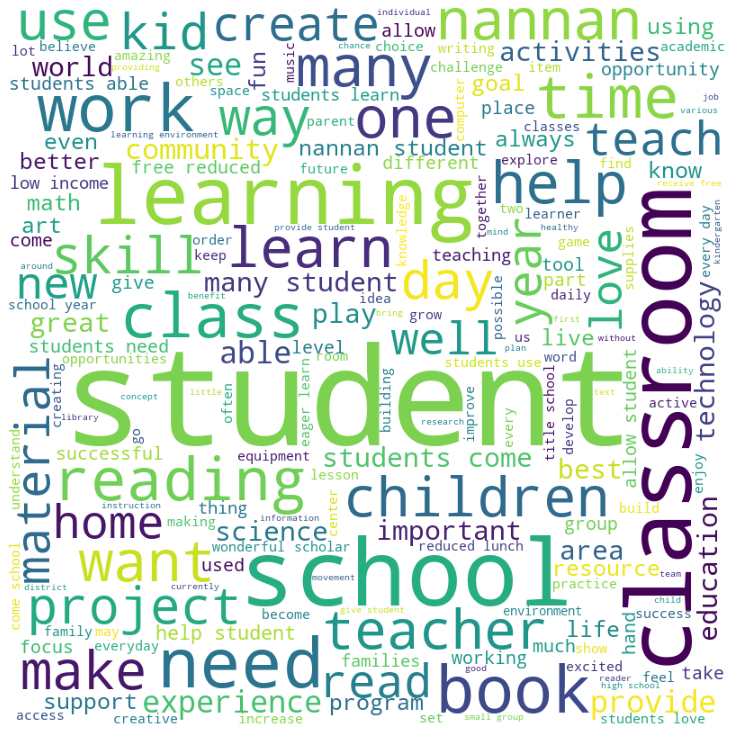

In [ ]:
#WORD CLOUD OF ESSAY
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  # typecaste each val to string 
  val = str(val)
  # split the value 
  tokens = val.split()
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()

  for words in tokens :
    comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

# plot the WordCloud image   
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#https://www.geeksforgeeks.org/generating-word-cloud-python/

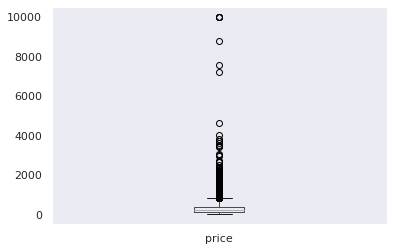

In [ ]:
X_test.boxplot( column =['price'], grid = False)

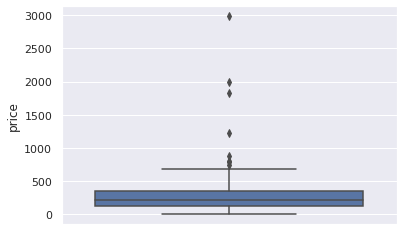

In [ ]:
#Plotting the box plot with the `price` of these `false positive data points`
#Box Plot (FP 'price')

cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))
sns.boxplot(y='price', data=X_test_falsePos1)




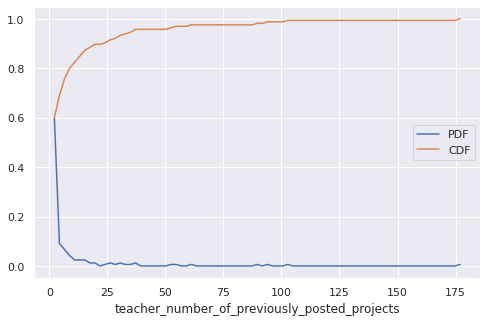

In [ ]:
#Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

In [1]:
# compare models using Prettytable library
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC ")
tb.add_row([" Tf - Idf", 10 , 500 ,0.62 ])
print(tb)

+--------------+-------------+--------------------+-------------+
|  Vectorizer  |  Max_depth  |  Min_sample_split  |  Test -AUC  |
+--------------+-------------+--------------------+-------------+
|   Tf - Idf   |      10     |        500         |     0.62    |
+--------------+-------------+--------------------+-------------+
